In [1]:
import sys
import platform
import os

import pandas as pd
import numpy as np
import sklearn as sk
import scipy as sp

import tensorflow as tf
import tensorflow.keras
import keras

import matplotlib.pyplot as plt
import seaborn as sns

from keras import utils

2023-05-25 15:43:58.025370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.3.1-x86_64-i386-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:17:34) [Clang 14.0.6 ]
Pandas 2.0.1
Scikit-Learn 1.2.2
SciPy 1.10.1
GPU is available


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Utils

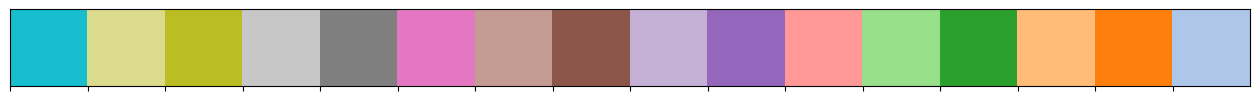

In [4]:
colors = sns.color_palette("tab20_r", 16)
sns.palplot(colors)
sns.set_style("darkgrid")

In [5]:
def plot_loss(hist, title):

    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    
    data = {'Epoch': range(1, len(train_acc) + 1),
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc,
           'Training Loss':train_loss,
           'Validation Loss':val_loss}
    df = pd.DataFrame(data)
    
    fig, ax = plt.subplots(figsize=(18,12))
    
    fig.suptitle(title, fontsize=20)
    
    sns.lineplot(ax=ax,data=df, x='Epoch', y='Training Loss', label='Training Loss')
    sns.lineplot(ax=ax,data=df, x='Epoch', y='Validation Loss', label='Validation Loss')
    
    ax.legend()
    
    
    return fig

In [6]:
def plot_accuracy(hist, title):

    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    
    data = {'Epoch': range(1, len(train_acc) + 1),
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc}
    df = pd.DataFrame(data)
    
    fig, ax = plt.subplots(figsize=(18,12))
    
    fig.suptitle(title, fontsize=20)
    
    sns.lineplot(ax=ax,data=df, x='Epoch', y='Training Accuracy', label='Training Accuracy')
    sns.lineplot(ax=ax,data=df, x='Epoch', y='Validation Accuracy', label='Validation Accuracy')
    
    ax.legend()
    
    
    return fig,df

# Load data

- The batch size specified in the code snippet is 16. 

- The batch size determines the number of samples that will be propagated through the network at each training iteration. 

- In this case, during training, the model will process 16 images at a time before updating the weights based on the calculated gradients. 

- Similarly, during validation and testing, the model will process the images in batches of 16.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
path = "/Users/manulabricole/Documents/CDN/MachineLearning/ML5/data/sports"

- This function loads images from the directory specified by '...../train' and creates a tf.data.Dataset object for the training dataset. 

- The labels for the images are inferred from the directory structure. 

- Each image is resized to (224, 224) pixels using bilinear interpolation. 

- The images are shuffled randomly, and the batch size is set to 16.

In [31]:
datagen = ImageDataGenerator(
    #rescale=1,  
    #rotation_range=0,  
    #width_shift_range=0, 
    #height_shift_range=0, 
    #shear_range=0,
    #zoom_range=0,
    #horizontal_flip=False,
    #fill_mode='nearest' 
)

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values between 0 and 1
    rotation_range=20,  # Randomly rotate images within the range of 20 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by 10% of the total width
    height_shift_range=0.1,  # Randomly shift images vertically by 10% of the total height
    shear_range=0.2,  # Apply shear transformations with a range of 0.2 radians
    zoom_range=0.2,  # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill any newly created pixels after rotation or shifting
)

In [33]:
train_generator = train_datagen.flow_from_directory(
    directory=path+"/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)
val_generator = train_datagen.flow_from_directory(
    directory=path+"/valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)
test_generator = train_datagen.flow_from_directory(
    directory=path+"/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [34]:
class_names = list(train_generator.class_indices.keys())
class_names

['air hockey',
 'ampute football',
 'archery',
 'arm wrestling',
 'axe throwing',
 'balance beam',
 'barell racing',
 'baseball',
 'basketball',
 'baton twirling',
 'bike polo',
 'billiards',
 'bmx',
 'bobsled',
 'bowling',
 'boxing',
 'bull riding',
 'bungee jumping',
 'canoe slamon',
 'cheerleading',
 'chuckwagon racing',
 'cricket',
 'croquet',
 'curling',
 'disc golf',
 'fencing',
 'field hockey',
 'figure skating men',
 'figure skating pairs',
 'figure skating women',
 'fly fishing',
 'football',
 'formula 1 racing',
 'frisbee',
 'gaga',
 'giant slalom',
 'golf',
 'hammer throw',
 'hang gliding',
 'harness racing',
 'high jump',
 'hockey',
 'horse jumping',
 'horse racing',
 'horseshoe pitching',
 'hurdles',
 'hydroplane racing',
 'ice climbing',
 'ice yachting',
 'jai alai',
 'javelin',
 'jousting',
 'judo',
 'lacrosse',
 'log rolling',
 'luge',
 'motorcycle racing',
 'mushing',
 'nascar racing',
 'olympic wrestling',
 'parallel bar',
 'pole climbing',
 'pole dancing',
 'pole vau

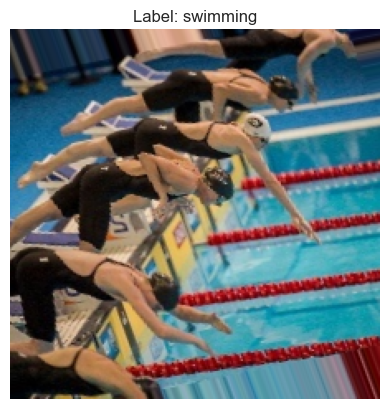

In [35]:
# Retrieve a batch of images and labels
images, labels = next(train_generator)
label_index = np.argmax(labels[0])
# Plot the first image in the batch
plt.imshow(images[0])
plt.title(f"Label: {class_names[label_index]}")
plt.axis('off')
plt.show()

### Notes

#### Batch size

- The batch size specified in the code snippet is 16. 
- The batch size determines the number of samples that will be propagated through the network at each training iteration. 
- In this case, during training, the model will process 16 images at a time before updating the weights based on the calculated gradients. Similarly, during validation and testing, the model will process the images in batches of 16.

- The choice of batch size can have an impact on training dynamics and memory usage. 
- A larger batch size can provide a more accurate estimate of the gradients but requires more memory. 
- On the other hand, a smaller batch size can lead to noisier gradient estimates but requires less memory.

- The batch size can be adjusted based on the available memory resources and the specific requirements of the training process.

### Data exploration

In [15]:
class_names = train_data.class_names
print(f"There are --> {len(class_names)} classes of sport")

There are --> 100 classes of sport


In [16]:
element_spec = train_data.element_spec
element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [17]:
train_data_list = list(train_data)

2023-05-25 15:44:14.929692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13492]
	 [[{{node Placeholder/_4}}]]
2023-05-25 15:44:14.930496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13492]
	 [[{{node Placeholder/_0}}]]


2023-05-25 15:44:17.304634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13492]
	 [[{{node Placeholder/_0}}]]
2023-05-25 15:44:17.304893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13492]
	 [[{{node Placeholder/_4}}]]


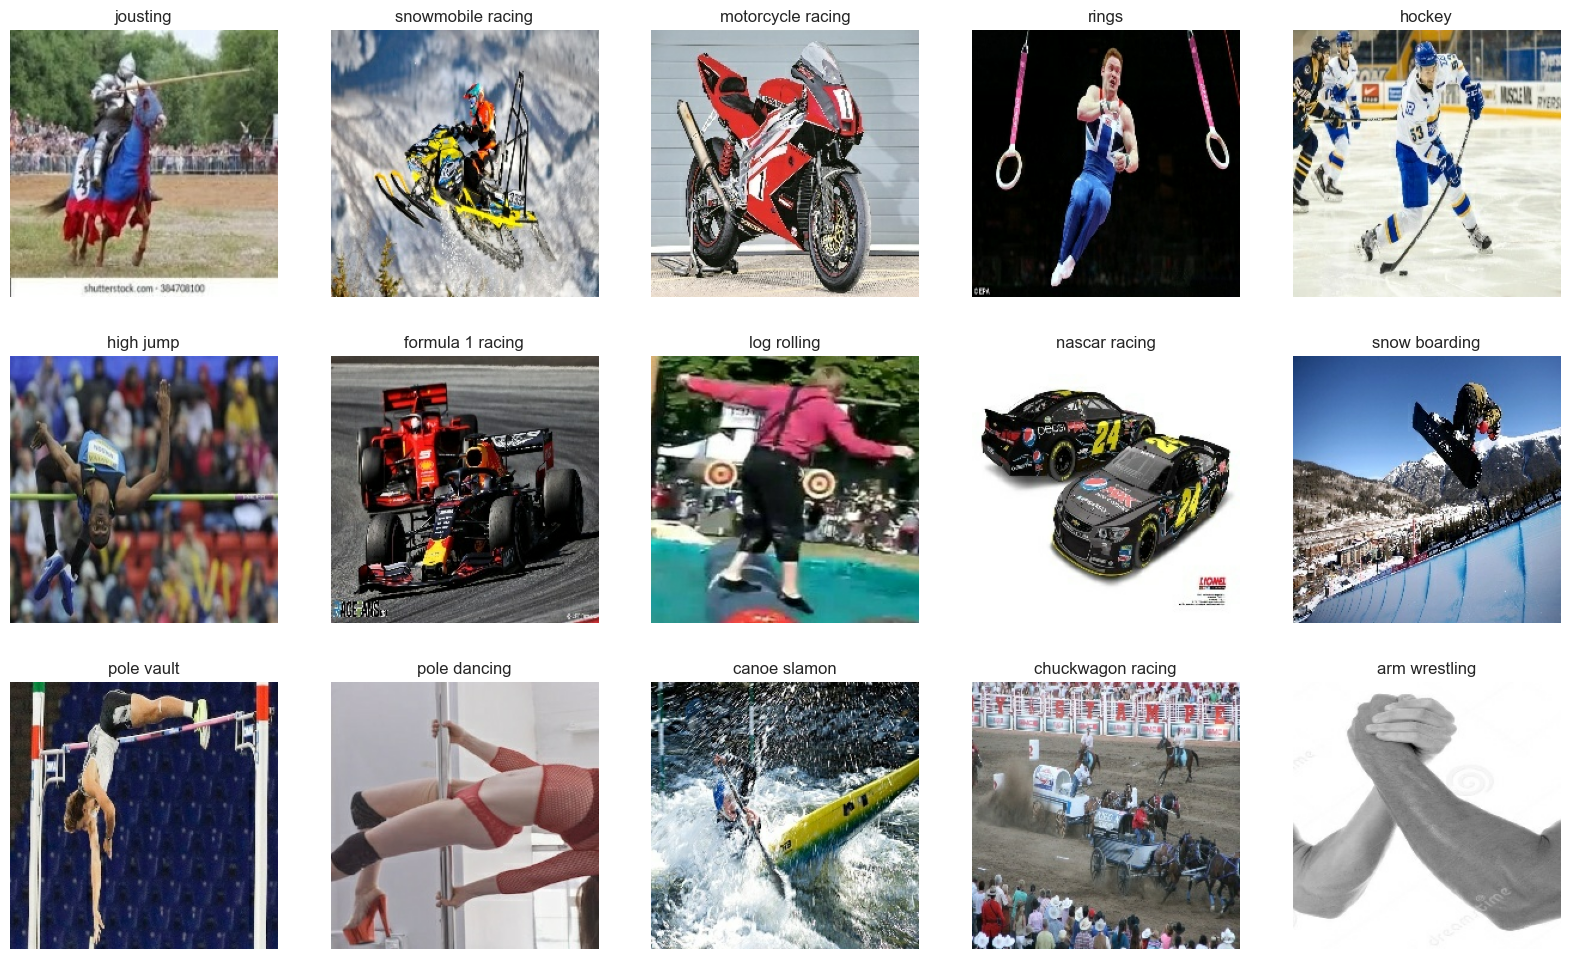

In [18]:
plt.figure(figsize=(20,12))
for x in train_data.take(1):
    for i in range(15):
        plt.subplot(3,5,i+1)
        image = x[0][i] / 255.
        plt.imshow(image)
        plt.title(class_names[x[1][i].numpy()])
        plt.axis('off')

In [19]:
for i, el in enumerate(train_data_list):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# First CNN

In [20]:
from tensorflow.keras import layers
from keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy

In [53]:
num_classes = len(class_names)

In [56]:
train_generator.class_indices

{'air hockey': 0,
 'ampute football': 1,
 'archery': 2,
 'arm wrestling': 3,
 'axe throwing': 4,
 'balance beam': 5,
 'barell racing': 6,
 'baseball': 7,
 'basketball': 8,
 'baton twirling': 9,
 'bike polo': 10,
 'billiards': 11,
 'bmx': 12,
 'bobsled': 13,
 'bowling': 14,
 'boxing': 15,
 'bull riding': 16,
 'bungee jumping': 17,
 'canoe slamon': 18,
 'cheerleading': 19,
 'chuckwagon racing': 20,
 'cricket': 21,
 'croquet': 22,
 'curling': 23,
 'disc golf': 24,
 'fencing': 25,
 'field hockey': 26,
 'figure skating men': 27,
 'figure skating pairs': 28,
 'figure skating women': 29,
 'fly fishing': 30,
 'football': 31,
 'formula 1 racing': 32,
 'frisbee': 33,
 'gaga': 34,
 'giant slalom': 35,
 'golf': 36,
 'hammer throw': 37,
 'hang gliding': 38,
 'harness racing': 39,
 'high jump': 40,
 'hockey': 41,
 'horse jumping': 42,
 'horse racing': 43,
 'horseshoe pitching': 44,
 'hurdles': 45,
 'hydroplane racing': 46,
 'ice climbing': 47,
 'ice yachting': 48,
 'jai alai': 49,
 'javelin': 50,
 '

In [76]:
train_generator.next()

(array([[[[0.91028684, 0.91028684, 0.91028684],
          [0.909178  , 0.909178  , 0.909178  ],
          [0.9080692 , 0.9080692 , 0.9080692 ],
          ...,
          [0.9245497 , 0.92549026, 0.9073729 ],
          [0.93007505, 0.9261535 , 0.9104672 ],
          [0.9331694 , 0.92924786, 0.9135616 ]],
 
         [[0.91372555, 0.91372555, 0.91372555],
          [0.9133612 , 0.9133612 , 0.9133612 ],
          [0.9122523 , 0.9122523 , 0.9122523 ],
          ...,
          [0.92752475, 0.92549026, 0.90886045],
          [0.9315626 , 0.92764103, 0.91195476],
          [0.934657  , 0.9307354 , 0.9176962 ]],
 
         [[0.91372555, 0.91372555, 0.91372555],
          [0.91372555, 0.91372555, 0.91372555],
          [0.91372555, 0.91372555, 0.91372555],
          ...,
          [0.92995584, 0.9260342 , 0.91034794],
          [0.9330501 , 0.9291285 , 0.91344225],
          [0.9361444 , 0.93222284, 0.9221587 ]],
 
         ...,
 
         [[0.91601545, 0.9258792 , 0.9055978 ],
          [0.94659

In [85]:
model = Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3))) 
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='softmax'))


model.add(layers.Flatten())
model.add(layers.Dense(100, activation='softmax'))

In [86]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
epochs = 10
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      832       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 16)      4112      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 56, 56, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 56, 56, 16)      

In [89]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [91]:
with tf.device('/GPU:0'):
    history = model4.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stop],
    )

Epoch 1/10


2023-05-25 16:20:22.301878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


422/422 [==============================] - ETA: 0s - loss: 2.8943 - accuracy: 0.2987

2023-05-25 16:22:39.190528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 142s 336ms/step - loss: 2.8943 - accuracy: 0.2987 - val_loss: 2.8401 - val_accuracy: 0.3180
Epoch 2/10
422/422 [==============================] - 142s 337ms/step - loss: 2.7563 - accuracy: 0.3214 - val_loss: 2.8033 - val_accuracy: 0.3300
Epoch 3/10
422/422 [==============================] - 141s 335ms/step - loss: 2.6911 - accuracy: 0.3385 - val_loss: 2.7602 - val_accuracy: 0.3100
Epoch 4/10
422/422 [==============================] - 140s 331ms/step - loss: 2.6273 - accuracy: 0.3566 - val_loss: 2.6626 - val_accuracy: 0.3620
Epoch 5/10
422/422 [==============================] - 140s 332ms/step - loss: 2.5603 - accuracy: 0.3678 - val_loss: 2.7015 - val_accuracy: 0.3580
Epoch 6/10
422/422 [==============================] - 147s 347ms/step - loss: 2.5178 - accuracy: 0.3740 - val_loss: 2.6129 - val_accuracy: 0.3640
Epoch 7/10
422/422 [==============================] - 151s 357ms/step - loss: 2.4896 - accuracy: 0.3790 - val_loss: 2.5863 - val_accura

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stop],
    )

Epoch 1/10


2023-05-25 16:47:00.871055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-25 16:47:01.372233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - ETA: 0s - loss: 4.6031 - accuracy: 0.0126

2023-05-25 16:49:20.099830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-25 16:49:20.164232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 144s 337ms/step - loss: 4.6031 - accuracy: 0.0126 - val_loss: 4.6067 - val_accuracy: 0.0100
Epoch 2/10
422/422 [==============================] - 144s 340ms/step - loss: 4.5805 - accuracy: 0.0176 - val_loss: 4.5658 - val_accuracy: 0.0160
Epoch 3/10
422/422 [==============================] - 145s 343ms/step - loss: 4.5116 - accuracy: 0.0227 - val_loss: 4.4794 - val_accuracy: 0.0220
Epoch 4/10
161/422 [==========>...................] - ETA: 1:27 - loss: 4.4443 - accuracy: 0.0247

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

In [94]:
# Evaluate the model on the test set
test_loss, test_acc = model4.evaluate(test_generator)
print('Test accuracy:', test_acc)

2023-05-25 16:46:49.572382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 5s 311ms/step - loss: 2.4512 - accuracy: 0.3980
Test accuracy: 0.39800000190734863
